In [1]:
import numpy as np
import sqlite3 as sq
import matplotlib.pyplot as plt
import matplotlib.collections
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import json
import matplotlib.text as mtext
from colors import Colors
import seaborn as sns

%matplotlib inline
# green mean, yellow median
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
connection = sq.connect("./performance-measurements/merged.db")
connection.row_factory = sq.Row

In [3]:
vantage_points = {
                  'US East':                  {'short': 'us-east_'},
                  'US West':                  {'short': 'us-west_'},
                  'South America East':       {'short': 'sa-east_'},
                  'Europe Central':           {'short': 'eu-central_'},
                  'Asia Pacific Southeast':   {'short': 'ap-southeast_'},
                  'Asia Pacific Northeast':   {'short': 'ap-northeast_'},
                  'Africa South':             {'short': 'af-south_'},
                  'All':                      {'short': ''}
                 }

In [4]:
# basically quic_drop_dups but also dropping all queries with errors
sql = """
CREATE TABLE IF NOT EXISTS dns_measurements_clean AS
SELECT * 
FROM (SELECT *, datetime(created, 'unixepoch') as created_date FROM dns_measurements WHERE id LIKE 'us-east_%' AND r_code IS NOT NULL)
GROUP BY strftime('%d', created_date), strftime('%H', created_date), protocol, ip, cache_warming
UNION ALL
SELECT * 
FROM (SELECT *, datetime(created, 'unixepoch') as created_date FROM dns_measurements WHERE id LIKE 'us-west_%' AND r_code IS NOT NULL)
GROUP BY strftime('%d', created_date), strftime('%H', created_date), protocol, ip, cache_warming
UNION ALL
SELECT * 
FROM (SELECT *, datetime(created, 'unixepoch') as created_date FROM dns_measurements WHERE id LIKE 'ap-northeast_%' AND r_code IS NOT NULL)
GROUP BY strftime('%d', created_date), strftime('%H', created_date), protocol, ip, cache_warming
UNION ALL
SELECT * 
FROM (SELECT *, datetime(created, 'unixepoch') as created_date FROM dns_measurements WHERE id LIKE 'af-south_%' AND r_code IS NOT NULL)
GROUP BY strftime('%d', created_date), strftime('%H', created_date), protocol, ip, cache_warming
UNION ALL
SELECT * 
FROM (SELECT *, datetime(created, 'unixepoch') as created_date FROM dns_measurements WHERE id LIKE 'eu-central_%' AND r_code IS NOT NULL)
GROUP BY strftime('%d', created_date), strftime('%H', created_date), protocol, ip, cache_warming
UNION ALL
SELECT * 
FROM (SELECT *, datetime(created, 'unixepoch') as created_date FROM dns_measurements WHERE id LIKE 'ap-southeast_%' AND r_code IS NOT NULL)
GROUP BY strftime('%d', created_date), strftime('%H', created_date), protocol, ip, cache_warming
UNION ALL
SELECT * 
FROM (SELECT *, datetime(created, 'unixepoch') as created_date FROM dns_measurements WHERE id LIKE 'sa-east_%' AND r_code IS NOT NULL)
GROUP BY strftime('%d', created_date), strftime('%H', created_date), protocol, ip, cache_warming;
"""
cursor = connection.cursor()
cursor.execute(sql)
connection.commit()
cursor.close()

In [5]:
sql = """
CREATE TABLE IF NOT EXISTS traceroutes_small AS
SELECT * 
FROM (SELECT * FROM traceroutes WHERE dest_ip == hop_ip)
WHERE dns_measurement_id IN (SELECT id FROM dns_measurements_clean);
"""
cursor = connection.cursor()
cursor.execute(sql)
connection.commit()
cursor.close()

In [6]:
def quic_drop_dups(measurements_quic):
    # not used, instead we create a cleaned table
    # drop duplicates on floored timestamp and ip -> this removes resolvers with doubled ports (e.g. adguard)
    measurements_quic['created_datetime'] = pd.to_datetime(measurements_quic['created'], unit='s')
    measurements_quic['created_datetime_hour'] = measurements_quic['created_datetime'].dt.floor('h')
    measurements_quic_cleaned = measurements_quic.drop_duplicates(['ip', 'created_datetime_hour'])
    measurements_quic_cleaned.drop(['created_datetime', 'created_datetime_hour'], axis=1, inplace=True)
    return measurements_quic_cleaned
    
def average(items, key):
    total = 0
    for item in items:
        try:
            total += item[key]
        except:
            pass
    return total/len(items)

def getTraceroutesForProtocol(protocol, vp=''):
    def generateStatement(protocol, vp):
        return "SELECT ip FROM dns_measurements_clean {} WHERE {}.protocol = '{}' AND {}.response_ip IS NOT NULL AND NOT {}.cache_warming AND measurement.id LIKE '{}%'".format(protocol, protocol, protocol, protocol, protocol, vp)
    statements = {
        "udp": generateStatement("udp", vp),
        "tcp": generateStatement("tcp", vp),
        "tls": generateStatement("tls", vp),
        "https": generateStatement("https", vp),
        "quic": generateStatement("quic", vp)
    }
    del statements[protocol]
    sql = """
    SELECT * from traceroutes WHERE (dns_measurement_id, hop_ip, dest_port, protocol) IN (SELECT id, ip, port, protocol FROM dns_measurements_clean measurement
    WHERE measurement.protocol = '{}' AND measurement.total_time IS NOT NULL AND measurement.total_time <= 5000000000
      AND measurement.id LIKE '{}%'
      AND NOT measurement.cache_warming
      AND measurement.ip IN ({})
      AND measurement.ip IN ({})
      AND measurement.ip IN ({})
      AND measurement.ip IN ({}));
    """.format(protocol, vp, *statements.values())
    df = pd.read_sql_query(sql, connection)
    return df

def getMeanTraceroutesPairwise(vp=''):
    udp = getTraceroutesForProtocolPairwise("udp", vp)["rtt"].div(1000000)
    tcp = getTraceroutesForProtocolPairwise("tcp", vp)["rtt"].div(1000000)
    tls = getTraceroutesForProtocolPairwise("tls", vp)["rtt"].div(1000000)
    https = getTraceroutesForProtocolPairwise("https", vp)["rtt"].div(1000000)
    quic = getTraceroutesForProtocolPairwise("quic", vp)["rtt"].div(1000000)
    
    fig = plt.figure(figsize = (10, 7))
    ax = fig.add_subplot(111)
    bp = ax.boxplot([udp.values.tolist(), tcp.values.tolist(), tls.values.tolist(), https.values.tolist(), quic.values.tolist()], vert = 0, showfliers = False)

    ax.set_yticklabels(["UDP", "TCP", "TLS", "HTTPS", "QUIC"])

    ax.set_xlabel("ms", fontsize = 12)
    ax.set_ylabel("Protocol", fontsize = 12)
    plt.title("RTT for Hosts with all Protocols Reachable")

    plt.show(bp)
    
    df = pd.DataFrame({ 
        "Protocol": ["UDP", "TCP", "TLS", "HTTPS", "QUIC"],
        "Samples": [len(udp), len(tcp), len(tls), len(https), len(quic)]
    })
    print(df.to_markdown())
    
def getTraceroutesForProtocolPairwise(protocol, vp=''):
    def generateStatement(protocol, vp):
        return "SELECT ip FROM dns_measurements_clean {} WHERE {}.protocol = '{}' AND {}.response_ip IS NOT NULL AND {}.id LIKE '{}%'".format(protocol, protocol, protocol, protocol, protocol, protocol, vp)
    statements = {
        "udp": generateStatement("udp", vp),
        "tcp": generateStatement("tcp", vp),
        "tls": generateStatement("tls", vp),
        "https": generateStatement("https", vp),
        "quic": generateStatement("quic", vp)
    }
    del statements[protocol]
    sql = """
    SELECT * from traceroutes_small WHERE dns_measurement_id LIKE '{}%' AND (dns_measurement_id, hop_ip, dest_port, protocol) IN (SELECT id, ip, port, protocol FROM dns_measurements_clean measurement
    WHERE measurement.protocol = '{}' AND measurement.total_time IS NOT NULL AND measurement.total_time <= 5000000000
      AND NOT measurement.cache_warming
      AND measurement.ip IN ({})
      AND measurement.ip IN ({})
      AND measurement.ip IN ({})
      AND measurement.ip IN ({})) 
      AND hop_ip IN (SELECT DISTINCT(hop_ip) FROM traceroutes_small WHERE protocol = 'udp')
      AND hop_ip IN (SELECT DISTINCT(hop_ip) FROM traceroutes_small WHERE protocol = 'quic')
      AND hop_ip IN (SELECT DISTINCT(hop_ip) FROM traceroutes_small WHERE protocol = 'tcp')
      AND hop_ip IN (SELECT DISTINCT(hop_ip) FROM traceroutes_small WHERE protocol = 'tls')
      AND hop_ip IN (SELECT DISTINCT(hop_ip) FROM traceroutes_small WHERE protocol = 'https');
    """.format(vp, protocol, *statements.values())
    df = pd.read_sql_query(sql, connection)
    return df

def getMeanTraceroutes(vp=''):
    udp_df = getTraceroutesForProtocolPairwise("udp", vp)
    udp_df["rtt"] = udp_df["rtt"].div(1000000)
    tcp_df = getTraceroutesForProtocolPairwise("tcp", vp)
    tcp_df["rtt"] = tcp_df["rtt"].div(1000000)
    tls_df = getTraceroutesForProtocolPairwise("tls", vp)
    tls_df["rtt"] = tls_df["rtt"].div(1000000)
    https_df = getTraceroutesForProtocolPairwise("https", vp)
    https_df["rtt"] = https_df["rtt"].div(1000000)
    quic_df = getTraceroutesForProtocolPairwise("quic", vp)
    quic_df["rtt"] = quic_df["rtt"].div(1000000)
    
    
    udp = udp_df.groupby("dest_ip")["rtt"].median().reset_index()["rtt"]
    tcp = tcp_df.groupby("dest_ip")["rtt"].median().reset_index()["rtt"]
    tls = tls_df.groupby("dest_ip")["rtt"].median().reset_index()["rtt"]
    https = https_df.groupby("dest_ip")["rtt"].median().reset_index()["rtt"]
    quic = quic_df.groupby("dest_ip")["rtt"].median().reset_index()["rtt"]
    
    return {'UDP': udp, 'TCP': tcp, 'TLS': tls, 'HTTPS': https, 'QUIC': quic}
        
def getQUICMedianTraceroutes(cacheWarming = False, protocol = "quic", vp=''):
    cacheCondition = "AND NOT d.cache_warming" if not cacheWarming else "AND d.cache_warming"
    sql = """
    SELECT
       d.id, d.ip, d.port, d.protocol, d.q_ui_c_handshake_duration as quic_handshake_duration, d.query_time, d.tcp_handshake_duration, d.tls_handshake_duration, d.total_time, d.q_ui_c_version
    FROM dns_measurements_clean d
    WHERE d.protocol = '{}' {}
    AND d.id LIKE '{}%'
    AND d.id IN (SELECT DISTINCT(t.dns_measurement_id) FROM traceroutes_small t where t.protocol = '{}');
    """.format(protocol, cacheCondition, vp, protocol)
    handshake_duration = pd.read_sql_query(sql, connection)
    sql = """
    SELECT
    t.dns_measurement_id as id, dest_port as port, protocol, dest_ip, hop_ip, rtt
    FROM traceroutes_small t
    WHERE t.protocol = '{}' AND id LIKE '{}%'
    """.format(protocol, vp)
    rtts = pd.read_sql_query(sql, connection).groupby("id").sample(n = 1)
    return pd.merge(handshake_duration, rtts, on = ["id", "protocol", "port"])

def getQUICMedianResolveTime(vp=''):
    sql = f"""
    SELECT ip, query_time FROM dns_measurements_clean measurement
    WHERE measurement.protocol = 'quic' AND measurement.total_time IS NOT NULL AND measurement.total_time <= 5000000000
      AND measurement.id LIKE '{vp}%'
      AND NOT measurement.cache_warming
      AND measurement.ip IN (SELECT ip FROM dns_measurements_clean udp WHERE udp.protocol = 'udp' AND udp.response_ip IS NOT NULL AND NOT udp.cache_warming)
      AND measurement.ip IN (SELECT ip FROM dns_measurements_clean tcp WHERE tcp.protocol = 'tcp' AND tcp.response_ip IS NOT NULL AND NOT tcp.cache_warming)
      AND measurement.ip IN (SELECT ip FROM dns_measurements_clean tls WHERE tls.protocol = 'tls' AND tls.response_ip IS NOT NULL AND NOT tls.cache_warming)
      AND measurement.ip IN (SELECT ip FROM dns_measurements_clean https WHERE https.protocol = 'https' AND https.response_ip IS NOT NULL AND NOT https.cache_warming);
    """
    quic_df = pd.read_sql_query(sql, connection)
    
    quic_df["query_time"] = quic_df["query_time"].div(1000000)
    
    quic = quic_df.groupby("ip")["query_time"].median().reset_index()
    return quic

def getUDP(vp=''):
    sql = f"""
    SELECT * FROM dns_measurements_clean measurement
    WHERE measurement.protocol = 'udp' AND measurement.total_time IS NOT NULL AND measurement.total_time <= 5000000000
      AND measurement.id LIKE '{vp}%'
      AND NOT measurement.cache_warming
      AND measurement.ip IN (SELECT ip FROM dns_measurements_clean tcp WHERE tcp.protocol = 'tcp' AND tcp.response_ip IS NOT NULL AND NOT tcp.cache_warming)
      AND measurement.ip IN (SELECT ip FROM dns_measurements_clean tls WHERE tls.protocol = 'tls' AND tls.response_ip IS NOT NULL AND NOT tls.cache_warming)
      AND measurement.ip IN (SELECT ip FROM dns_measurements_clean https WHERE https.protocol = 'https' AND https.response_ip IS NOT NULL AND NOT https.cache_warming)
      AND measurement.ip IN (SELECT ip FROM dns_measurements_clean quic WHERE quic.protocol = 'quic' AND quic.response_ip IS NOT NULL AND NOT quic.cache_warming);
    """
    cursor = connection.cursor()
    cursor.execute(sql)
    items = list(cursor.fetchall())
    cursor.close()
    return items

def getTCP(vp=''):
    sql = f"""
    SELECT * FROM dns_measurements_clean measurement
    WHERE measurement.protocol = 'tcp' AND measurement.total_time IS NOT NULL AND measurement.total_time <= 5000000000
      AND measurement.id LIKE '{vp}%'
      AND NOT measurement.cache_warming
      AND measurement.ip IN (SELECT ip FROM dns_measurements_clean udp WHERE udp.protocol = 'udp' AND udp.response_ip IS NOT NULL AND NOT udp.cache_warming)
      AND measurement.ip IN (SELECT ip FROM dns_measurements_clean tls WHERE tls.protocol = 'tls' AND tls.response_ip IS NOT NULL AND NOT tls.cache_warming)
      AND measurement.ip IN (SELECT ip FROM dns_measurements_clean https WHERE https.protocol = 'https' AND https.response_ip IS NOT NULL AND NOT https.cache_warming)
      AND measurement.ip IN (SELECT ip FROM dns_measurements_clean quic WHERE quic.protocol = 'quic' AND quic.response_ip IS NOT NULL AND NOT quic.cache_warming);
    """
    cursor = connection.cursor()
    cursor.execute(sql)
    items = list(cursor.fetchall())
    cursor.close()
    return items

def getTLS(vp=''):
    sql = f"""
    SELECT * FROM dns_measurements_clean measurement
    WHERE measurement.protocol = 'tls' AND measurement.total_time IS NOT NULL AND measurement.total_time <= 5000000000
      AND measurement.id LIKE '{vp}%'
      AND NOT measurement.cache_warming
      AND measurement.ip IN (SELECT ip FROM dns_measurements_clean udp WHERE udp.protocol = 'udp' AND udp.response_ip IS NOT NULL AND NOT udp.cache_warming)
      AND measurement.ip IN (SELECT ip FROM dns_measurements_clean tcp WHERE tcp.protocol = 'tcp' AND tcp.response_ip IS NOT NULL AND NOT tcp.cache_warming)
      AND measurement.ip IN (SELECT ip FROM dns_measurements_clean https WHERE https.protocol = 'https' AND https.response_ip IS NOT NULL AND NOT https.cache_warming)
      AND measurement.ip IN (SELECT ip FROM dns_measurements_clean quic WHERE quic.protocol = 'quic' AND quic.response_ip IS NOT NULL AND NOT quic.cache_warming);
    """
    cursor = connection.cursor()
    cursor.execute(sql)
    items = list(cursor.fetchall())
    cursor.close()
    return items

def getHTTPS(vp=''):
    sql = f"""
    SELECT * FROM dns_measurements_clean measurement
    WHERE measurement.protocol = 'https' AND measurement.total_time IS NOT NULL AND measurement.total_time <= 5000000000
      AND measurement.id LIKE '{vp}%'
      AND NOT measurement.cache_warming
      AND measurement.ip IN (SELECT ip FROM dns_measurements_clean udp WHERE udp.protocol = 'udp' AND udp.response_ip IS NOT NULL AND NOT udp.cache_warming)
      AND measurement.ip IN (SELECT ip FROM dns_measurements_clean tcp WHERE tcp.protocol = 'tcp' AND tcp.response_ip IS NOT NULL AND NOT tcp.cache_warming)
      AND measurement.ip IN (SELECT ip FROM dns_measurements_clean tls WHERE tls.protocol = 'tls' AND tls.response_ip IS NOT NULL AND NOT tls.cache_warming)
      AND measurement.ip IN (SELECT ip FROM dns_measurements_clean quic WHERE quic.protocol = 'quic' AND quic.response_ip IS NOT NULL AND NOT quic.cache_warming);
    """
    cursor = connection.cursor()
    cursor.execute(sql)
    items = list(cursor.fetchall())
    cursor.close()
    return items

def getQUIC(vp=''):
    sql = f"""
    SELECT * FROM dns_measurements_clean measurement
    WHERE measurement.protocol = 'quic' AND measurement.total_time IS NOT NULL AND measurement.total_time <= 5000000000
      AND measurement.id LIKE '{vp}%'
      AND NOT measurement.cache_warming
      AND measurement.ip IN (SELECT ip FROM dns_measurements_clean udp WHERE udp.protocol = 'udp' AND udp.response_ip IS NOT NULL AND NOT udp.cache_warming)
      AND measurement.ip IN (SELECT ip FROM dns_measurements_clean tcp WHERE tcp.protocol = 'tcp' AND tcp.response_ip IS NOT NULL AND NOT tcp.cache_warming)
      AND measurement.ip IN (SELECT ip FROM dns_measurements_clean tls WHERE tls.protocol = 'tls' AND tls.response_ip IS NOT NULL AND NOT tls.cache_warming)
      AND measurement.ip IN (SELECT ip FROM dns_measurements_clean https WHERE https.protocol = 'https' AND https.response_ip IS NOT NULL AND NOT https.cache_warming);
    """
    cursor = connection.cursor()
    cursor.execute(sql)
    items = list(cursor.fetchall())
    cursor.close()
    return items

def getQUICNegotiatedProtocol(vp=''):
    sql = f"""
    SELECT DISTINCT(measurement.ip), measurement.q_ui_c_negotiated_protocol FROM dns_measurements_clean measurement
    WHERE measurement.protocol = 'quic'
    AND NOT measurement.cache_warming
    AND measurement.id LIKE '{vp}%';
    """
    cursor = connection.cursor()
    cursor.execute(sql)
    items = list(cursor.fetchall())
    cursor.close()
    return items

def getQUICVersions(vp=''):
    sql = f"""
    SELECT DISTINCT(measurement.ip), measurement.q_ui_c_version FROM dns_measurements_clean measurement
    WHERE measurement.protocol = 'quic'
    AND NOT measurement.cache_warming
    AND measurement.id LIKE '{vp}%';
    """
    cursor = connection.cursor()
    cursor.execute(sql)
    items = list(cursor.fetchall())
    cursor.close()
    return items

def getNumberOfSamples(vp=''):
    udp = len(getUDP(vp))
    tcp = len(getTCP(vp))
    tls = len(getTLS(vp))
    https = len(getHTTPS(vp))
    quic = len(getQUIC(vp))
    return pd.DataFrame({ 
        "Protocol": ["UDP", "TCP", "TLS", "HTTPS", "QUIC"],
        "Samples": [udp, tcp, tls, https, quic]
    })

def getData(vp=''):
    udp = getUDP(vp)
    tcp = getTCP(vp)
    tls = getTLS(vp)
    https = getHTTPS(vp)
    quic = getQUIC(vp)
    return pd.DataFrame(udp + tcp + tls + https + quic, columns = udp[0].keys())

def calculateCDF(items):
    count, bins_count = np.histogram(items, bins="auto")

    pdf = count / sum(count)

    # using numpy np.cumsum to calculate the CDF
    # We can also find using the PDF values by looping and adding
    cdf = np.cumsum(pdf)
    return bins_count[1:], cdf

def setBoxesWhite(bp):
    for patch in bp['boxes']:
        patch.set_facecolor("white")

In [7]:
def count_no_cw(vp=''):
    sql = f"""
    SELECT * FROM dns_measurements measurement
    WHERE measurement.id LIKE '{vp}%'
    AND NOT measurement.cache_warming;
    """
    cursor = connection.cursor()
    cursor.execute(sql)
    items = list(cursor.fetchall())
    cursor.close()
    return len(items)

def count_no_response(vp=''):
    sql = f"""
    SELECT * FROM dns_measurements measurement
    WHERE measurement.id LIKE '{vp}%'
    AND NOT measurement.cache_warming
    AND measurement.r_code IS NULL;
    """
    cursor = connection.cursor()
    cursor.execute(sql)
    items = list(cursor.fetchall())
    cursor.close()
    return len(items)

def count_error(vp=''):
    sql = f"""
    SELECT * FROM dns_measurements measurement
    WHERE measurement.id LIKE '{vp}%'
    AND NOT measurement.cache_warming
    AND measurement.r_code != 0;
    """
    cursor = connection.cursor()
    cursor.execute(sql)
    items = list(cursor.fetchall())
    cursor.close()
    return len(items)

def count_timeout(vp=''):
    sql = f"""
    SELECT * FROM dns_measurements measurement
    WHERE measurement.id LIKE '{vp}%'
    AND NOT measurement.cache_warming
    AND measurement.r_code = 0
    AND measurement.total_time > 5000000000;
    """
    cursor = connection.cursor()
    cursor.execute(sql)
    items = list(cursor.fetchall())
    cursor.close()
    return len(items)

for key, vp in vantage_points.items():
    short = vp['short']
    print(key)
    print(f"No CW: {count_no_cw(short)}")
    print(f"No Response: {count_no_response(short)}")
    print(f"Error: {count_error(short)}")
    print(f"Timeout: {count_timeout(short)}")

US East
No CW: 637349
No Response: 369810
Error: 13949
Timeout: 146
US West
No CW: 637271
No Response: 367897
Error: 13992
Timeout: 121
South America East
No CW: 637345
No Response: 368796
Error: 13893
Timeout: 144
Europe Central
No CW: 636906
No Response: 372890
Error: 14370
Timeout: 199
Asia Pacific Southeast
No CW: 637794
No Response: 368472
Error: 14071
Timeout: 159
Asia Pacific Northeast
No CW: 631004
No Response: 364865
Error: 13754
Timeout: 183
Africa South
No CW: 637293
No Response: 370169
Error: 13704
Timeout: 184
All
No CW: 4454962
No Response: 2582899
Error: 97733
Timeout: 1136


### Total Servers used

In [9]:
for key, vp in vantage_points.items():
    print(key)
    vp['allData'] = getData(vp['short'])
    print(len(vp['allData']["ip"].unique()))

US East
262
US West
262
South America East
262
Europe Central
262
Asia Pacific Southeast
262
Asia Pacific Northeast
262
Africa South
262
All
262


In [10]:
for key, vp in vantage_points.items():
    vp['UDP'] = getUDP(vp['short'])
    vp['TCP'] = getTCP(vp['short'])
    vp['TLS'] = getTLS(vp['short'])
    vp['HTTPS'] = getHTTPS(vp['short'])
    vp['QUIC'] = getQUIC(vp['short'])

### Average Total Times

In [11]:
for key, vp in vantage_points.items():
    vp['average_total_time'] = {
        'UDP': average(vp['UDP'], "total_time") / 1000000,
        'TCP': average(vp['TCP'], "total_time") / 1000000,
        'TLS': average(vp['TLS'], "total_time") / 1000000,
        'HTTPS': average(vp['HTTPS'], "total_time") / 1000000,
        'QUIC': average(vp['QUIC'], "total_time") / 1000000
    }

In [12]:
row_labels = [key for key in vantage_points]
col_labels = ['UDP', 'TCP', 'TLS', 'HTTPS', 'QUIC']
total_times = [[vp['average_total_time'][protocol] for protocol in col_labels] for key, vp in vantage_points.items()]
total_times_df = pd.DataFrame(total_times, columns=col_labels, index=row_labels)
total_times_df.style.background_gradient(cmap='RdYlGn_r')

,UDP,TCP,TLS,HTTPS,QUIC
US East,139.917670,286.247424,436.841256,434.062111,377.085713
US West,135.191767,273.973761,420.655535,418.974563,371.575174
South America East,251.267034,510.571395,773.031120,764.812753,638.197335
Europe Central,135.125921,277.491347,426.606204,417.646548,364.367790
Asia Pacific Southeast,201.032332,406.525155,622.501689,609.785939,523.032729
Asia Pacific Northeast,152.724122,315.025863,483.643161,480.922502,415.299873
Africa South,269.657535,542.894567,825.920905,817.447543,668.614917
All,183.926930,373.962646,570.883677,563.865131,479.745998


In [13]:
total_times_df.style.background_gradient(cmap='RdYlGn_r', axis=1)

,UDP,TCP,TLS,HTTPS,QUIC
US East,139.917670,286.247424,436.841256,434.062111,377.085713
US West,135.191767,273.973761,420.655535,418.974563,371.575174
South America East,251.267034,510.571395,773.031120,764.812753,638.197335
Europe Central,135.125921,277.491347,426.606204,417.646548,364.367790
Asia Pacific Southeast,201.032332,406.525155,622.501689,609.785939,523.032729
Asia Pacific Northeast,152.724122,315.025863,483.643161,480.922502,415.299873
Africa South,269.657535,542.894567,825.920905,817.447543,668.614917
All,183.926930,373.962646,570.883677,563.865131,479.745998


<AxesSubplot:>

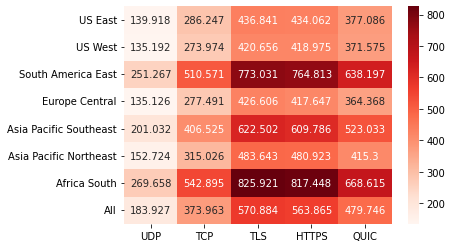

In [14]:
sns.heatmap(total_times_df, annot=True, fmt='g', cmap='Reds')

#### Number of Samples

In [15]:
for key, vp in vantage_points.items():
    vp['number_of_samples'] = getNumberOfSamples(vp['short']).set_index("Protocol")
total_samples = [[vp['number_of_samples'].loc[protocol]['Samples'] for protocol in col_labels] for key, vp in vantage_points.items()]
total_samples_df = pd.DataFrame(total_samples, columns=col_labels, index=row_labels)
total_samples_df

,UDP,TCP,TLS,HTTPS,QUIC
US East,20047,20043,20000,19898,20965
US West,20436,20439,20442,20286,20965
South America East,20435,20446,20381,20103,20958
Europe Central,19690,19718,19714,19544,20882
Asia Pacific Southeast,20458,20493,20472,20059,21009
Asia Pacific Northeast,20147,20228,20243,20069,20864
Africa South,20316,20338,20332,20047,20881
All,141529,141705,141584,140006,146524


### Comparing Protocols

In [16]:
for key, vp in vantage_points.items():
    vp['query_time'] = {
    'UDP': list(map(lambda x: x["query_time"] / 1000000, vp['UDP'])),
    'TCP': list(map(lambda x: x["query_time"] / 1000000, vp['TCP'])),
    'TLS': list(map(lambda x: x["query_time"] / 1000000, vp['TLS'])),
    'HTTPS': list(map(lambda x: x["query_time"] / 1000000, vp['HTTPS'])),
    'QUIC': list(map(lambda x: x["query_time"] / 1000000, vp['QUIC']))
    }

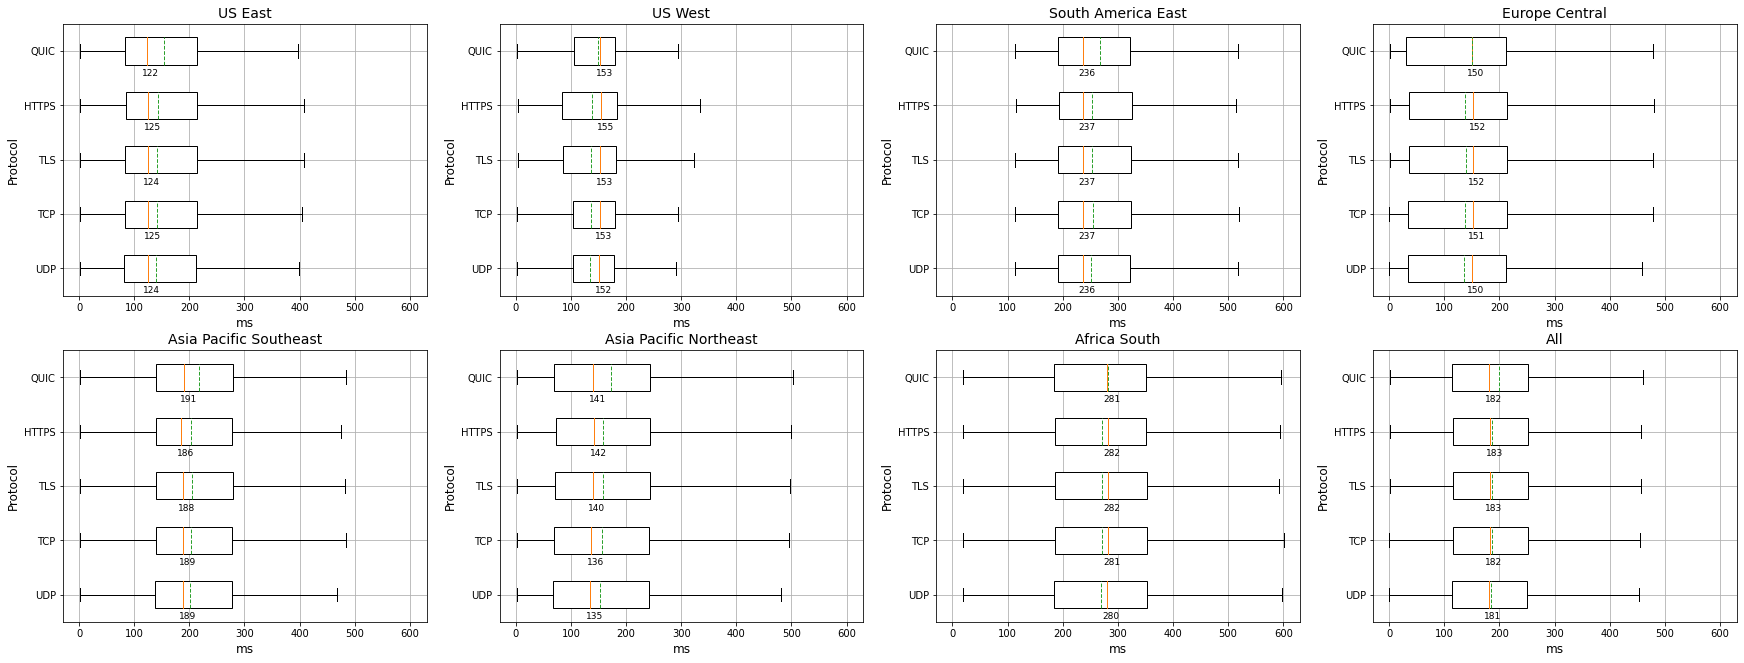

In [17]:
i = 0
fig, axs = plt.subplots(2, 4, figsize=(30, 11), sharex=True)
for key, vp in vantage_points.items():
    qt = vp['query_time']
    ax = axs[int(i/4),i%4]
    bp = ax.boxplot([qt['UDP'], qt['TCP'], qt['TLS'], qt['HTTPS'], qt['QUIC']], vert = 0, sym = "", patch_artist=True, meanline = True, showmeans = True)
    setBoxesWhite(bp)

    for median in bp["medians"]:
        x, y = median.get_data()
        ax.text(x[0] - 8, y[0] - 0.2, "{:.0f}".format(x[0]), fontsize = 9, color='black')

    ax.set_yticklabels(["UDP", "TCP", "TLS", "HTTPS", "QUIC"])
    ax.tick_params(labelbottom=True)
    ax.set_xlabel('ms', fontsize = 12)
    ax.set_ylabel("Protocol", fontsize = 12)
    ax.set_title(key, fontsize = 14)
    ax.grid()
    i += 1

plt.savefig("figures/resolve_time_boxplot.pdf", bbox_inches='tight')
plt.show()

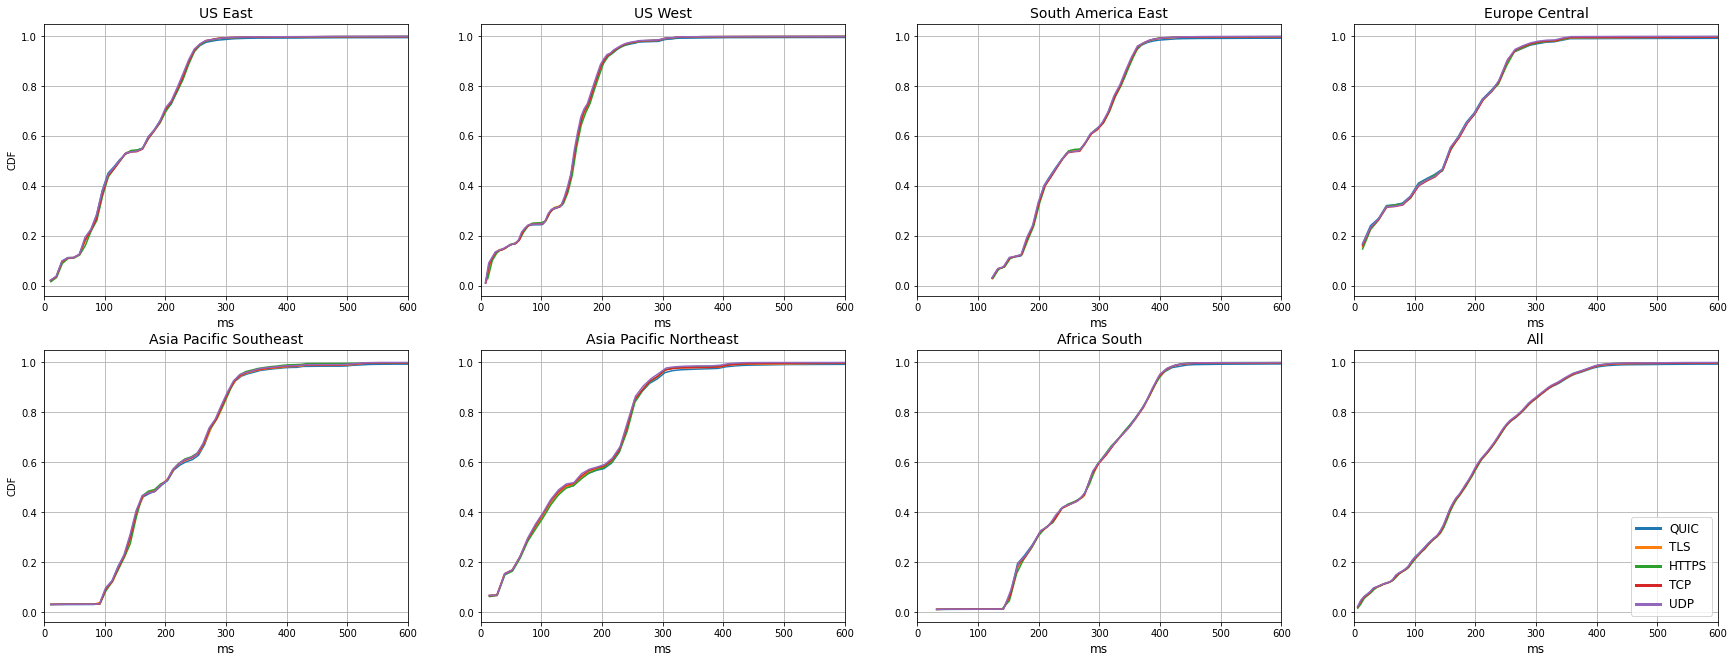

In [18]:
i = 0
fig, axs = plt.subplots(2, 4, figsize=(30, 11), sharey=True)

for key, vp in vantage_points.items():
    qt = vp['query_time']
    ax = axs[int(i/4),i%4]
    sns.lineplot(x=calculateCDF(qt['QUIC'])[0], y=calculateCDF(qt['QUIC'])[1], label="QUIC", ax=ax)
    sns.lineplot(x=calculateCDF(qt['TLS'])[0], y=calculateCDF(qt['TLS'])[1], label="TLS", ax=ax)
    sns.lineplot(x=calculateCDF(qt['HTTPS'])[0], y=calculateCDF(qt['HTTPS'])[1], label="HTTPS", ax=ax)
    sns.lineplot(x=calculateCDF(qt['TCP'])[0], y=calculateCDF(qt['TCP'])[1], label="TCP", ax=ax)
    sns.lineplot(x=calculateCDF(qt['UDP'])[0], y=calculateCDF(qt['UDP'])[1], label="UDP", ax=ax)
    
    ax.set_xlim(0, 600)
    ax.tick_params(labelleft=True)
    ax.set_xlabel("ms", fontsize = 12)
    ax.set_ylabel("CDF")
    ax.set_title(key, fontsize = 14)
    
    if i == 7:
        leg = ax.legend(loc="lower right", fontsize='large')
        for line in leg.get_lines():
            line.set_linewidth(3.0)
    else:
        ax.get_legend().remove()
    ax.grid()
    i += 1
    
plt.savefig("figures/resolve_time_cdf.pdf", bbox_inches='tight')
plt.show()

### Average resolve time

In [19]:
for key, vp in vantage_points.items():
    vp['average_query_time'] = {
        'UDP': round(average(vp['UDP'], "query_time") / 1000000, 2),
        'TCP': round(average(vp['TCP'], "query_time") / 1000000, 2),
        'TLS': round(average(vp['TLS'], "query_time") / 1000000, 2),
        'HTTPS': round(average(vp['HTTPS'], "query_time") / 1000000, 2),
        'QUIC': round(average(vp['QUIC'], "query_time") / 1000000, 2)
    }

In [20]:
for key, vp in vantage_points.items():
    vp['total_time'] = {
    'UDP': list(map(lambda x: x["total_time"] / 1000000, vp['UDP'])),
    'TCP': list(map(lambda x: x["total_time"] / 1000000, vp['TCP'])),
    'TLS': list(map(lambda x: x["total_time"] / 1000000, vp['TLS'])),
    'HTTPS': list(map(lambda x: x["total_time"] / 1000000, vp['HTTPS'])),
    'QUIC': list(map(lambda x: x["total_time"] / 1000000, vp['QUIC']))
    }

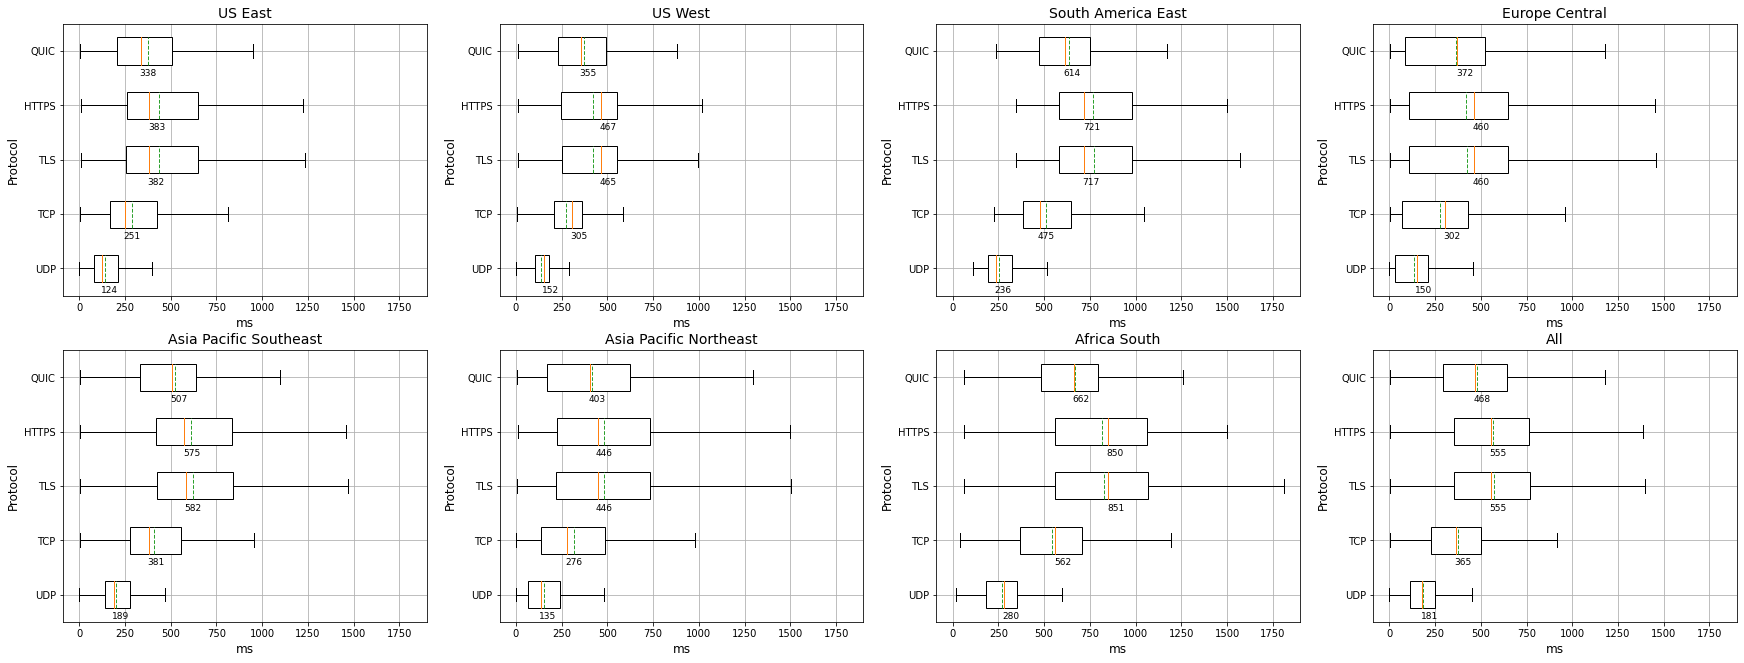

In [21]:
i = 0
fig, axs = plt.subplots(2, 4, figsize=(30, 11), sharex=True)
for key, vp in vantage_points.items():
    tt = vp['total_time']
    ax = axs[int(i/4),i%4]
    bp = ax.boxplot([tt['UDP'], tt['TCP'], tt['TLS'], tt['HTTPS'], tt['QUIC']], vert = 0, sym = "", patch_artist=True, meanline = True, showmeans = True)
    setBoxesWhite(bp)

    for median in bp["medians"]:
        x, y = median.get_data()
        ax.text(x[0] - 8, y[0] - 0.2, "{:.0f}".format(x[0]), fontsize = 9, color='black')
    
    ax.set_yticklabels(["UDP", "TCP", "TLS", "HTTPS", "QUIC"])
    ax.set_xlabel('ms', fontsize = 12)
    ax.set_ylabel("Protocol", fontsize = 12)
    ax.set_title(key, fontsize = 14)
    ax.tick_params(labelbottom=True)
    ax.grid()
    i += 1

plt.savefig("figures/total_time_boxplot.pdf", bbox_inches='tight')
plt.show()

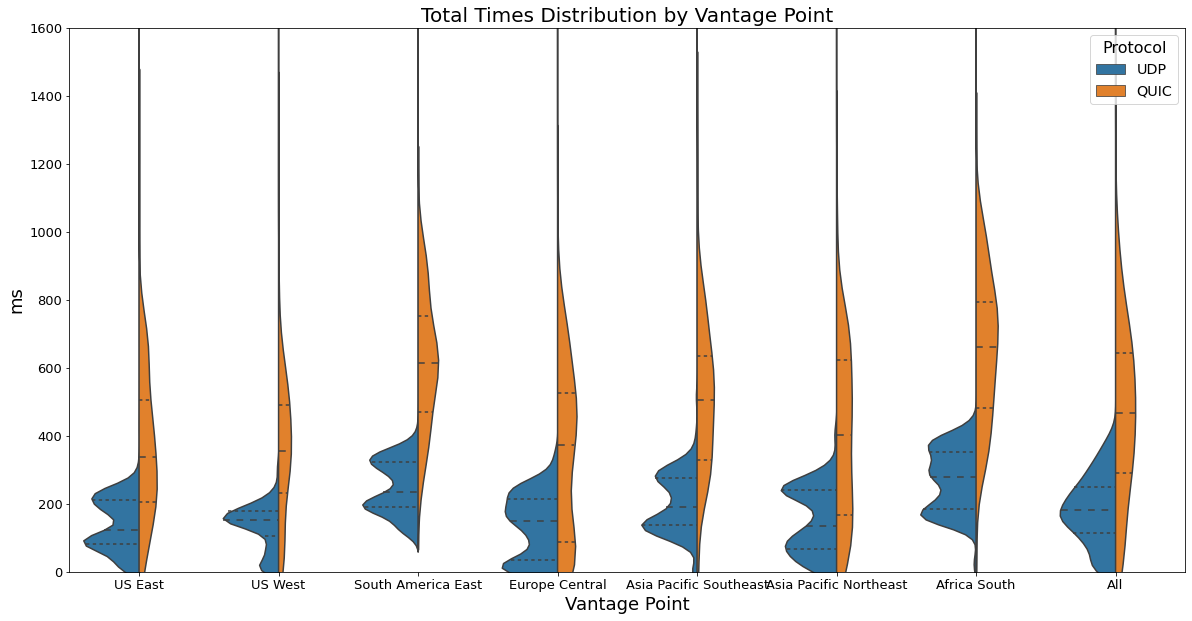

In [22]:
prot_1 = 'UDP'
prot_2 = 'QUIC'

fig, ax = plt.subplots(figsize=(20, 10))
x = []
y = []
z = []
for key, vp in vantage_points.items():
    ttu = vp['total_time'][prot_1]
    x.extend(len(ttu) * [key])
    y.extend(ttu)
    z.extend(len(ttu) * [prot_1])
    
    ttq = vp['total_time'][prot_2]
    x.extend(len(ttq) * [key])
    y.extend(ttq)
    z.extend(len(ttq) * [prot_2])
    
data = pd.DataFrame(dict(x=x, y=y, z=z))

ax.set_title('Total Times Distribution by Vantage Point', fontsize = 20)
ax.set_ylim(0, 1600)

v = sns.violinplot(data=data, x='x', y='y',
               split=True, hue = 'z',
               ax = ax, inner='quartile',
               bw = 0.3)
v.set_xlabel('Vantage Point', fontsize = 18)
v.set_ylabel('ms', fontsize = 18)
v.tick_params(labelsize=13)

plt.legend(title='Protocol', fontsize='x-large', title_fontsize='16')
plt.savefig("figures/total_time_violinplot.pdf", bbox_inches='tight')
plt.show()

In [23]:
for key, vp in vantage_points.items():
    vp['setup_time'] = {
    'UDP': list(map(lambda x: x["udp_socket_setup_duration"] / 1000000, vp['UDP'])),
    'TCP': list(map(lambda x: x["tcp_handshake_duration"] / 1000000, vp['TCP'])),
    'TLS': list(map(lambda x: (x["tcp_handshake_duration"] + x["tls_handshake_duration"]) / 1000000, vp['TLS'])),
    'HTTPS': list(map(lambda x: (x["tcp_handshake_duration"] + x["tls_handshake_duration"]) / 1000000, vp['HTTPS'])),
    'QUIC': list(map(lambda x: x["q_ui_c_handshake_duration"] / 1000000, vp['QUIC']))
    }

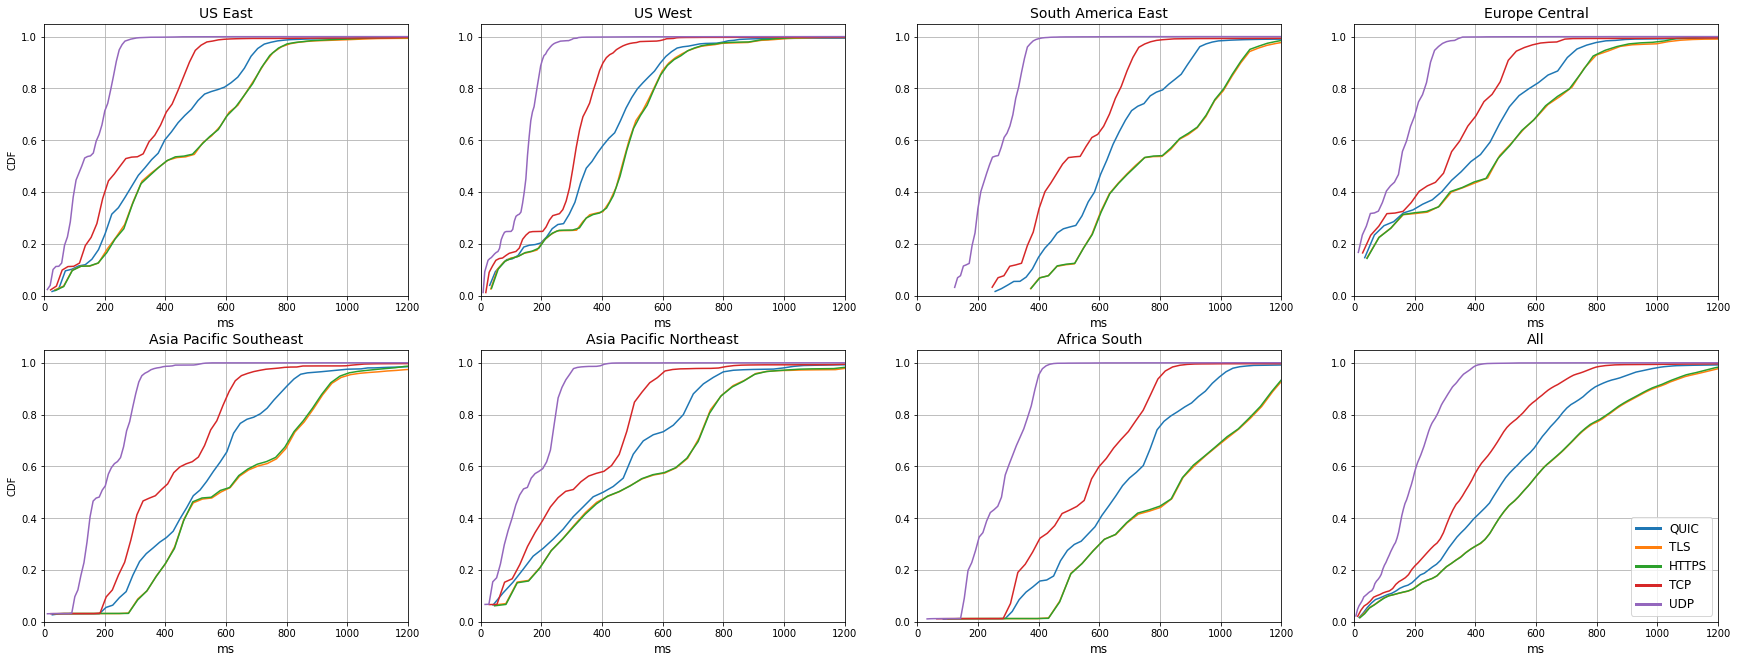

In [25]:
i = 0
fig, axs = plt.subplots(2, 4, figsize=(30, 11), sharey=True)

for key, vp in vantage_points.items():
    tt = vp['total_time']
    ax = axs[int(i/4),i%4]
    sns.lineplot(x=calculateCDF(tt['QUIC'])[0], y=calculateCDF(tt['QUIC'])[1], label="QUIC", ax=ax)
    sns.lineplot(x=calculateCDF(tt['TLS'])[0], y=calculateCDF(tt['TLS'])[1], label="TLS", ax=ax)
    sns.lineplot(x=calculateCDF(tt['HTTPS'])[0], y=calculateCDF(tt['HTTPS'])[1], label="HTTPS", ax=ax)
    sns.lineplot(x=calculateCDF(tt['TCP'])[0], y=calculateCDF(tt['TCP'])[1], label="TCP", ax=ax)
    sns.lineplot(x=calculateCDF(tt['UDP'])[0], y=calculateCDF(tt['UDP'])[1], label="UDP", ax=ax)

    ax.set_xlim(0, 1200)
    ax.set_ylim(0.0)
    ax.tick_params(labelleft=True)
    ax.set_xlabel("ms", fontsize = 12)
    ax.set_ylabel("CDF")
    ax.set_title(key, fontsize = 14)
    
    if i == 7:
        leg = ax.legend(loc="lower right", fontsize='large')
        for line in leg.get_lines():
            line.set_linewidth(3.0)
    else:
        ax.get_legend().remove()
    ax.grid()
    i += 1
    
plt.savefig("figures/total_time_cdf.pdf", bbox_inches='tight')
plt.show()

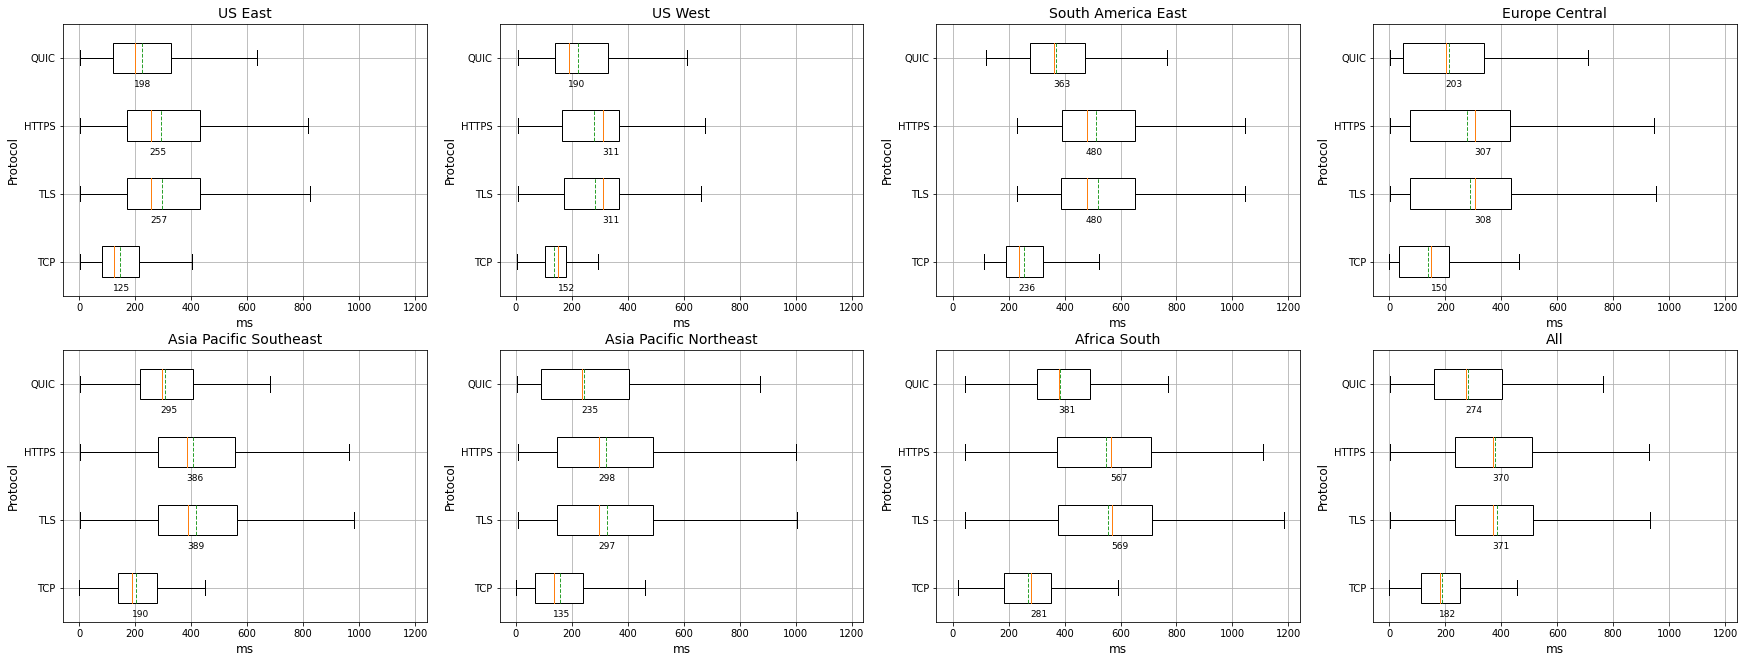

In [24]:
i = 0
fig, axs = plt.subplots(2, 4, figsize=(30, 11), sharex=True)
for key, vp in vantage_points.items():
    st = vp['setup_time']
    ax = axs[int(i/4),i%4]
    bp = ax.boxplot([st['TCP'], st['TLS'], st['HTTPS'], st['QUIC']], vert = 0, showfliers = False, patch_artist=True, meanline = True, showmeans = True)
    setBoxesWhite(bp)

    for median in bp["medians"]:
        x, y = median.get_data()
        ax.text(x[0] - 3, y[0] - 0.2, "{:.0f}".format(x[0]), fontsize = 9, color='black')

    ax.set_yticklabels(["TCP", "TLS", "HTTPS", "QUIC"])
    ax.set_xlabel("ms", fontsize = 12)
    ax.set_ylabel("Protocol", fontsize = 12)
    ax.set_title(key, fontsize = 14)
    ax.tick_params(labelbottom=True)
    ax.grid()
    i += 1


plt.savefig("figures/handshake_time_boxplot.pdf", bbox_inches='tight')
plt.show(bp)

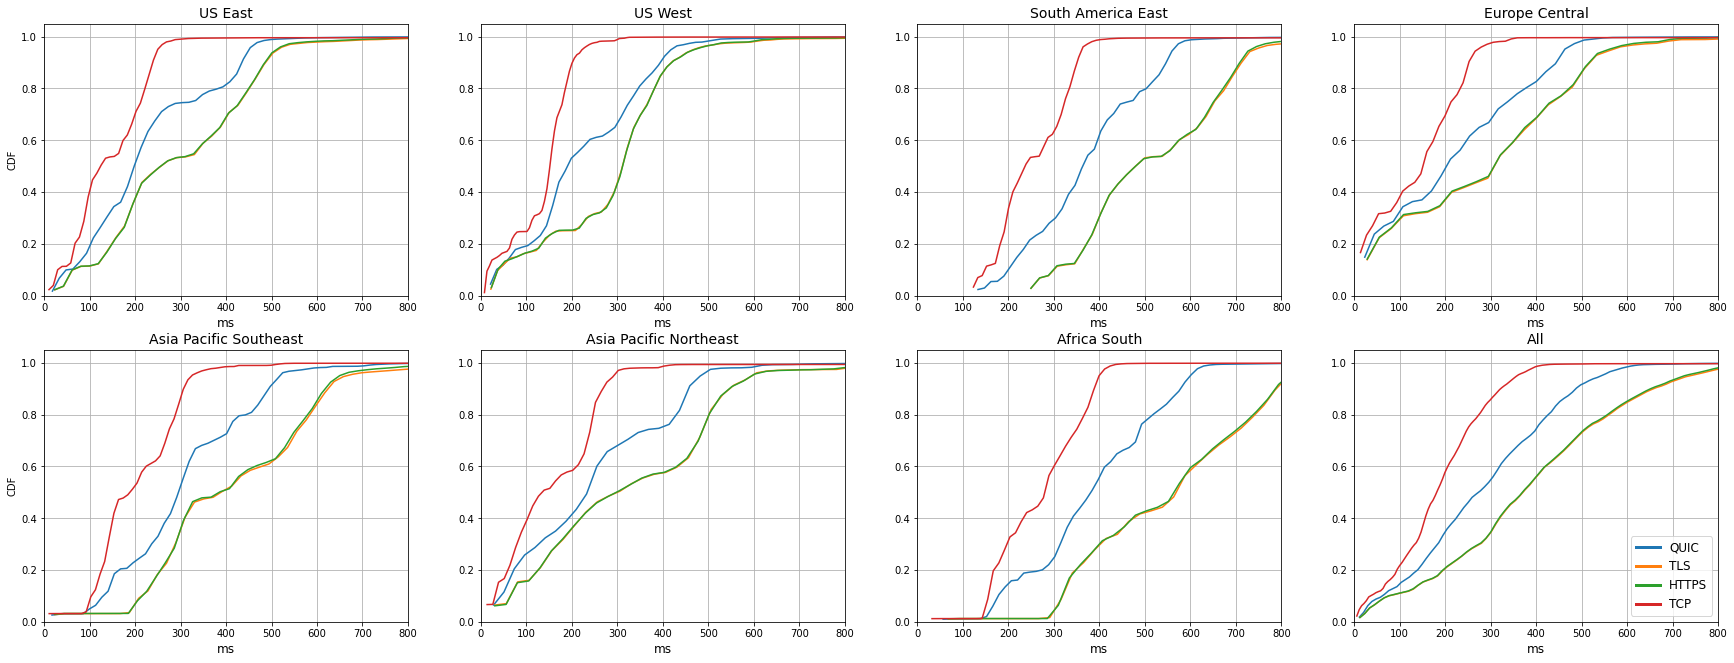

In [26]:
i = 0
fig, axs = plt.subplots(2, 4, figsize=(30, 11), sharey=True)

for key, vp in vantage_points.items():
    st = vp['setup_time']
    ax = axs[int(i/4),i%4]
    sns.lineplot(x=calculateCDF(st['QUIC'])[0], y=calculateCDF(st['QUIC'])[1], label="QUIC", ax=ax)
    sns.lineplot(x=calculateCDF(st['TLS'])[0], y=calculateCDF(st['TLS'])[1], label="TLS", ax=ax)
    sns.lineplot(x=calculateCDF(st['HTTPS'])[0], y=calculateCDF(st['HTTPS'])[1], label="HTTPS", ax=ax)
    sns.lineplot(x=calculateCDF(st['TCP'])[0], y=calculateCDF(st['TCP'])[1], label="TCP", ax=ax)

    ax.set_xlim(0, 800)
    ax.set_ylim(0.0)
    ax.tick_params(labelleft=True)
    ax.set_xlabel("ms", fontsize = 12)
    ax.set_ylabel("CDF")
    ax.set_title(key, fontsize = 14)
    if i == 7:
        leg = ax.legend(loc="lower right", fontsize='large')
        for line in leg.get_lines():
            line.set_linewidth(3.0)
    else:
        ax.get_legend().remove()
    ax.grid()
    i += 1
    
plt.savefig("figures/setup_time_cdf.pdf", bbox_inches='tight')
plt.show()

In [78]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx, array[idx]

def print_cdf_values(dict_key, percentage):
    data = {'QUIC': [], 'TLS': [], 'HTTPS': [], 'TCP': []}
    keys = []
    for key, vp in vantage_points.items():
        keys.append(key)
        st = vp[dict_key]

        x,y = calculateCDF(st['QUIC'])
        idx, val = find_nearest(y, percentage)
        data['QUIC'].append(int(x[idx]))

        x,y = calculateCDF(st['TLS'])
        idx, val = find_nearest(y, percentage)
        data['TLS'].append(int(x[idx]))

        x,y = calculateCDF(st['HTTPS'])
        idx, val = find_nearest(y, percentage)
        data['HTTPS'].append(int(x[idx]))

        x,y = calculateCDF(st['TCP'])
        idx, val = find_nearest(y, percentage)
        data['TCP'].append(int(x[idx]))
        
    return pd.DataFrame(data, keys)

In [79]:
worst_005 = print_cdf_values('setup_time', 0.995)

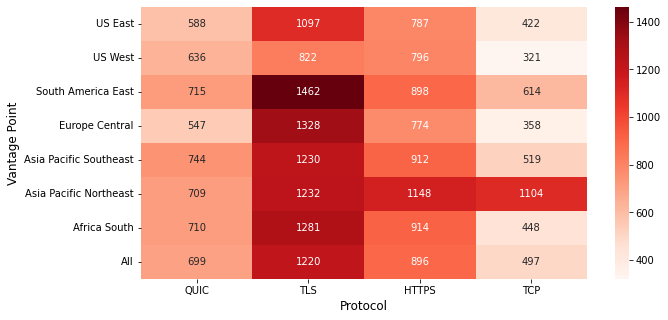

In [69]:
fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(worst_005, annot=True, fmt='g', cmap='Reds')
ax.set_ylabel("Vantage Point", fontsize=12)
ax.set_xlabel("Protocol", fontsize=12)
plt.savefig("figures/heatmap_worst_005.pdf", bbox_inches='tight')
plt.show()

In [101]:
#print_cdf_values('total_time', 0.33)
print_cdf_values('total_time', 0.9)

,QUIC,TLS,HTTPS,TCP
US East,660,725,716,479
US West,591,620,637,403
South America East,890,1066,1067,710
Europe Central,702,758,788,508
Asia Pacific Southeast,801,949,915,610
Asia Pacific Northeast,733,832,828,531
Africa South,949,1171,1167,768
All,781,993,984,650


### Traceroutes per Protocol

In [27]:
for key, vp in vantage_points.items():
    vp['mean_traceroutes'] = getMeanTraceroutes(vp['short'])

i = 0
fig, axs = plt.subplots(2, 4, figsize=(30, 11), sharex=True)
for key, vp in vantage_points.items():
    mt = vp['mean_traceroutes']
    ax = axs[int(i/4),i%4]
    bp = ax.boxplot([mt['UDP'].values.tolist(), mt['TCP'].values.tolist(), mt['TLS'].values.tolist(), mt['HTTPS'].values.tolist(), mt['QUIC'].values.tolist()], vert = 0, sym = "", patch_artist=True, meanline = True, showmeans = True)
    setBoxesWhite(bp)

    for median in bp["medians"]:
        x, y = median.get_data()
        ax.text(x[0] - 4, y[0] - 0.2, "{:.0f}".format(x[0]), fontsize = 9, color='black')

    ax.set_yticklabels(["UDP", "TCP", "TLS", "HTTPS", "QUIC"])
    ax.set_xlabel("ms", fontsize = 12)
    ax.set_ylabel("Protocol", fontsize = 12)
    ax.set_title(key, fontsize = 14)
    ax.tick_params(labelbottom=True)
    ax.grid()
    i += 1

plt.savefig("figures/median_traceroutes_boxplot.pdf", bbox_inches='tight')
plt.show()

### QUIC Handshake Duration / RTT

In [28]:
for key, vp in vantage_points.items():
    vp['times'] = getQUICMedianTraceroutes(vp=vp['short'])
    vp['times']['handshake/rtt'] = vp['times'].apply(lambda row: row["quic_handshake_duration"]/row["rtt"], axis = 1)
    vp['times']['resolve-rtt'] = vp['times'].apply(lambda row: (row["query_time"] - row["rtt"]) / 1000000, axis = 1)

In [72]:
for key, vp in vantage_points.items():
    print(vp['times'])

                                 id              ip  port protocol  \
0      us-east_c6dovn9mgmvdf5991m4g   1.116.116.195   784     quic   
1      us-east_c6dos81mgmvdf59912b0   1.116.151.233   784     quic   
2      us-east_c6dolapmgmvdf598vr8g     1.116.56.25   784     quic   
3      us-east_c6dp4apmgmvdf5992fl0    1.117.174.35   784     quic   
4      us-east_c6douvpmgmvdf5991ht0    1.15.174.179   784     quic   
...                             ...             ...   ...      ...   
80262  us-east_c6iaudhmgmv5dv79cg9g   95.168.168.70   784     quic   
80263  us-east_c6iabkhmgmv5dv7995q0    95.169.1.180   784     quic   
80264  us-east_c6iamrhmgmv5dv79b5k0  95.179.134.211  8853     quic   
80265  us-east_c6iav4hmgmv5dv79cka0  95.179.180.194   784     quic   
80266  us-east_c6iajj9mgmv5dv79aj70   98.154.23.186   784     quic   

       quic_handshake_duration  query_time tcp_handshake_duration  \
0                    199682007   197716404                   None   
1                    

In [29]:
for key, vp in vantage_points.items():
    vp['times_uncached'] = getQUICMedianTraceroutes(cacheWarming = True, vp=vp['short'])
    vp['times_uncached']["resolve-rtt"] = vp['times_uncached'].apply(lambda row: (row["query_time"] - row["rtt"]) / 1000000, axis = 1)

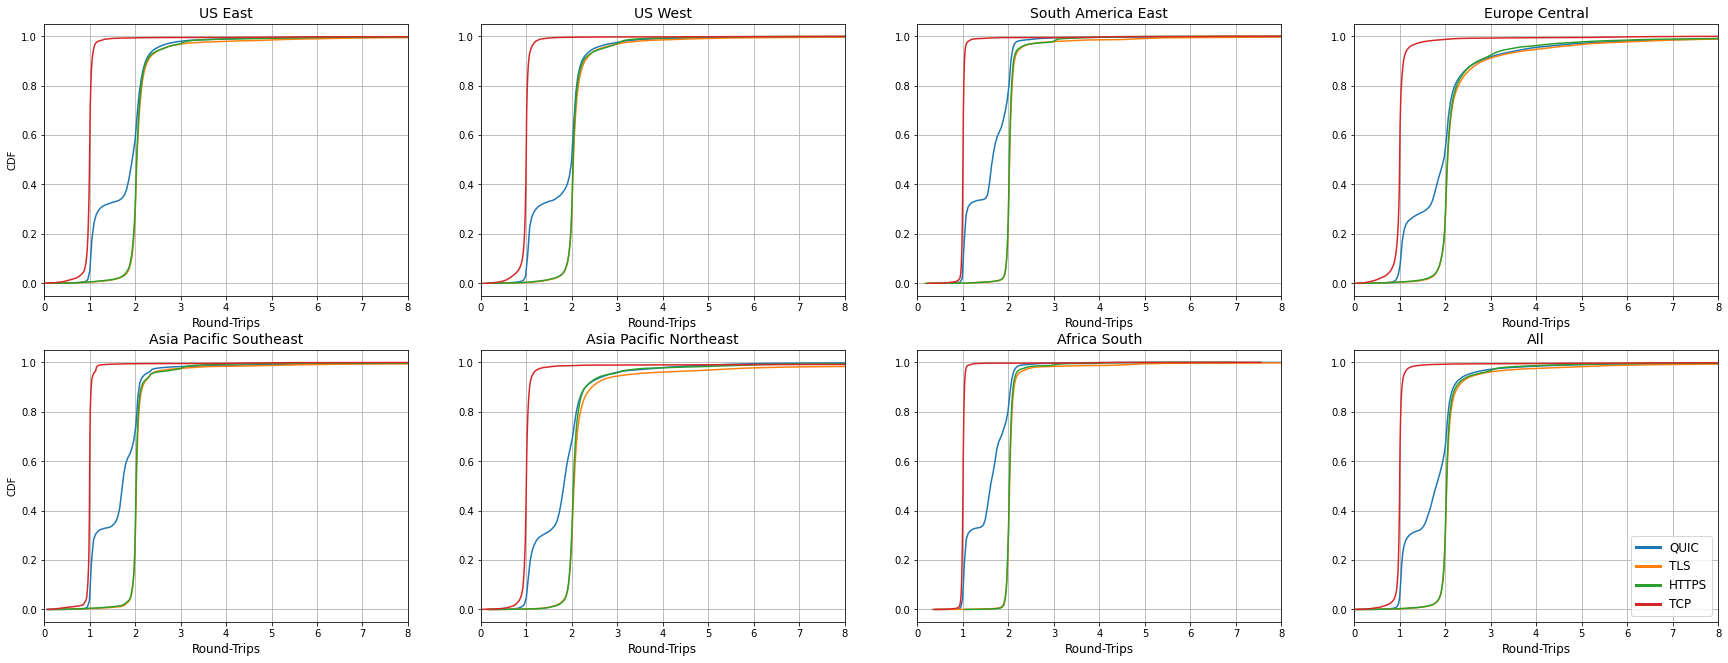

In [30]:
def plotHandshake(ax, vp):
    def filterNA(df):
        return df[df["handshake/rtt"].notna()]["handshake/rtt"].tolist()
    
    def addTLS(row):
        if row["tcp_handshake_duration"] and row["tls_handshake_duration"]:
            return (row["tcp_handshake_duration"] + row["tls_handshake_duration"])/row["rtt"]
        return np.nan
    
    vp_short=vp['short']
    quicTimes = getQUICMedianTraceroutes(protocol = "quic", vp=vp_short)
    tcpTimes = getQUICMedianTraceroutes(protocol = "tcp", vp=vp_short)
    tlsTimes = getQUICMedianTraceroutes(protocol = "tls", vp=vp_short)
    httpsTimes = getQUICMedianTraceroutes(protocol = "https", vp=vp_short)
    quicTimes["handshake/rtt"] = quicTimes.apply(lambda row: row["quic_handshake_duration"]/row["rtt"], axis = 1)
    tcpTimes["handshake/rtt"] = tcpTimes.apply(lambda row: row["tcp_handshake_duration"]/row["rtt"], axis = 1)
    tlsTimes["handshake/rtt"] = tlsTimes.apply(addTLS, axis = 1)
    httpsTimes["handshake/rtt"] = httpsTimes.apply(addTLS, axis = 1)
    
    distQUIC = filterNA(quicTimes)
    distTCP = filterNA(tcpTimes)
    distTLS = filterNA(tlsTimes)
    distHTTPS = filterNA(httpsTimes)
    
    sns.lineplot(x=calculateCDF(distQUIC)[0], y=calculateCDF(distQUIC)[1], label="QUIC", ax=ax)
    sns.lineplot(x=calculateCDF(distTLS)[0], y=calculateCDF(distTLS)[1], label="TLS", ax=ax)
    sns.lineplot(x=calculateCDF(distHTTPS)[0], y=calculateCDF(distHTTPS)[1], label="HTTPS", ax=ax)
    sns.lineplot(x=calculateCDF(distTCP)[0], y=calculateCDF(distTCP)[1], label="TCP", ax=ax)

    ax.set_xlim(0, 8)
    ax.tick_params(labelleft=True)
    ax.set_xlabel("Round-Trips", fontsize = 12)
    ax.set_ylabel("CDF")
    ax.set_title(key, fontsize = 14)
    
    if i == 7:
        leg = ax.legend(loc="lower right", fontsize='large')
        for line in leg.get_lines():
            line.set_linewidth(3.0)
    else:
        ax.get_legend().remove()
    ax.grid()
    plt.xlabel("Round-Trips", fontsize = 12)


i = 0
fig, axs = plt.subplots(2, 4, figsize=(30, 11), sharey=True)
for key, vp in vantage_points.items():
    plotHandshake(axs[int(i/4),i%4], vp)
    i += 1
plt.savefig("figures/handshake-rtt.pdf", bbox_inches='tight')
plt.show()

In [31]:
connection.close()